In [1]:
import os

In [2]:
# check if already in right local directory
# otherwise clone the repo from github and change directory

cwd = os.getcwd()
print(os.path.split(cwd))

if not os.path.split(cwd)[1] == "MA":
    !git clone https://www.github.com/JohnnyNewman/MA.git
    os.chdir('MA')

('C:\\Users\\Nils\\Workspace\\MA_git', 'MA')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.decomposition import PCA
import pickle

In [3]:
plt.style.use("dark_background")

### First, load the data:

In [33]:
aoa = pickle.load(open("save/T007/AOA_mat.p", "rb"))
ma = pickle.load(open("save/T007/Ma_mat.p", "rb"))
dv_list = pickle.load(open("save/T007/dv_list.p", "rb"))
df_result = pd.read_excel("save/T007/df_result.xlsx")
df_surface = pickle.load(open("save/T007/df_surface.p", "rb"))
df_cd_grad = pickle.load(open("save/T007/df_cd_grad.p", "rb"))


In [21]:
df_result #, df_result.shape

,Unnamed: 0,DIR,c_L,c_D,rms_rho,rms_nu
0,0,T007 DSN_0000,0.684430,0.017240,-2.984686,-4.584574
1,1,T007 DSN_0001,1.272203,0.328490,-3.868707,-6.913635
2,2,T007 DSN_0002,0.014759,0.008549,-7.000219,-8.926493
3,3,T007 DSN_0003,0.707919,0.226788,-7.000047,-7.421932
4,4,T007 DSN_0004,-0.610737,0.199593,-7.000050,-8.793758
...,...,...,...,...,...,...
2232,2232,T007 DSN_2232,-0.432334,0.079548,-7.000217,-7.206913
2233,2233,T007 DSN_2233,1.856224,0.739008,-6.984427,-9.407842
2234,2234,T007 DSN_2234,1.090870,0.036591,-7.000073,-8.929317
2235,2235,T007 DSN_2235,0.912005,0.446323,-6.128166,-5.045149


In [28]:
N = df_result.shape[0]
N

2237

In [23]:
df_cd_grad

,VAR,CD_GRAD,STEP,DIR
0,0,1.287410,0.001,T007 DSN_0000
1,1,1.182820,0.001,T007 DSN_0000
2,2,0.948446,0.001,T007 DSN_0000
3,3,0.685041,0.001,T007 DSN_0000
4,4,0.436186,0.001,T007 DSN_0000
...,...,...,...,...
33,33,-343.103000,0.001,T007 DSN_2236
34,34,-66.484900,0.001,T007 DSN_2236
35,35,562.844000,0.001,T007 DSN_2236
36,36,852.436000,0.001,T007 DSN_2236


### Then the non-converged results (rms_rho < -6) are removed from the dataset:

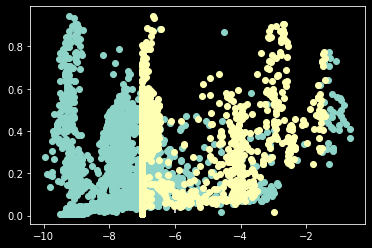

In [24]:
plt.plot(df_result["rms_nu"], df_result["c_D"], "o", label="nu")
plt.plot(df_result["rms_rho"], df_result["c_D"], "o")
plt.vlines([-6], 0.01, 0.1, ls="--")

In [35]:
sim_converged = df_result["rms_rho"] < -6
print(sim_converged.shape)

dv_mat = np.asarray(dv_list)[:N][sim_converged]
c_D = df_result["c_D"].values[sim_converged]
d_CD = np.resize(df_cd_grad["CD_GRAD"].values, ((N, 38)))[sim_converged]
aoa = aoa[:N][sim_converged]
ma = ma[:N][sim_converged]

(2237,)


In [36]:
aoa.shape

(1836,)

In [37]:
d_CD.shape[0]

1836

### Calculation of the covariance matrix and eigenvalue decomposition:

In [38]:
C = np.zeros((38,38))
for i in range(d_CD.shape[0]):
    C += np.outer(d_CD[i], d_CD[i])
C = C / d_CD.shape[0]

In [39]:
i = 0
np.outer(d_CD[i], d_CD[i]), d_CD[i]*d_CD[0,i]

(array([[ 3.24760045,  2.86110192,  2.24411352, ..., -0.39201299,
         -0.17919227,  0.22717579],
        [ 2.86110192,  2.52060077,  1.97704046, ..., -0.34535933,
         -0.15786651,  0.20013949],
        [ 2.24411352,  1.97704046,  1.55069737, ..., -0.27088358,
         -0.12382305,  0.15697998],
        ...,
        [-0.39201299, -0.34535933, -0.27088358, ...,  0.0473193 ,
          0.02163003, -0.02742205],
        [-0.17919227, -0.15786651, -0.12382305, ...,  0.02163003,
          0.00988726, -0.01253484],
        [ 0.22717579,  0.20013949,  0.15697998, ..., -0.02742205,
         -0.01253484,  0.01589138]]),
 array([ 3.24760045e+00,  2.86110192e+00,  2.24411352e+00,  1.59421859e+00,
         9.95698213e-01,  4.92345463e-01,  1.04057436e-01, -1.66829072e-01,
        -3.31125098e-01, -4.08233780e-01, -4.21264838e-01, -3.92566236e-01,
        -3.40721333e-01, -2.79793796e-01, -2.20592681e-01, -1.72233239e-01,
        -1.40573410e-01, -1.20120904e-01, -8.46344743e-02,  2.5990390

In [40]:
### Bishop 2006 PRML p. 83
d_CD_mean = d_CD.mean(axis=0)
np.outer(d_CD_mean, d_CD_mean)[:2,:3], d_CD_mean[0]*d_CD_mean[0], d_CD_mean[0]*d_CD_mean[1], d_CD_mean[1]*d_CD_mean[2]

(array([[504.09263734, 550.53203285, 477.75986192],
        [550.53203285, 601.2496449 , 521.77335774]]),
 504.0926373437755,
 550.5320328532499,
 521.7733577400052)

In [41]:
d_CD_mean

array([-22.45200742, -24.52039243, -21.27916016, -14.7092073 ,
        -6.31532598,   2.50068088,  10.48171033,  16.66083676,
        20.50715007,  21.99300344,  21.52112718,  19.69827323,
        17.02962901,  13.70531736,   9.669551  ,   4.98763272,
         0.1512644 ,  -4.43474701,  -6.5928032 , -15.68476924,
       -13.16915656,  -5.71650007,   5.17605393,  18.03491733,
        31.24544942,  43.17805879,  52.39921078,  57.89195862,
        59.21386912,  56.51913832,  50.40142882,  41.58065019,
        30.57744363,  17.65170658,   3.41074122,  -9.12237455,
        -8.08053472,  21.56995786])

In [42]:
#C = C - d_CD_mean

In [43]:
d_CD[i].reshape(1, -1).T @ d_CD[i].reshape(1, -1) - np.outer(d_CD[i], d_CD[i])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
C = np.dot(d_CD.T - d_CD_mean.T.reshape(-1,1), d_CD - d_CD_mean.reshape(1,-1)) / d_CD.shape[0]

In [45]:
n_samples = d_CD.shape[0]

In [46]:
C.shape

(38, 38)

In [47]:
#covariance.shape

In [48]:
from scipy.linalg import svd

In [49]:
U, S, Vt = linalg.svd(C)

In [50]:
### from sklearn PCA:
### # Center data
### self.mean_ = np.mean(X, axis=0)
### X -= self.mean_

In [51]:
        
explained_variance_ = (S ** 2) / (n_samples - 1)
total_var = explained_variance_.sum()
explained_variance_ratio_ = explained_variance_ / total_var
singular_values_ = S.copy()  # Store the singular values.

In [52]:
explained_variance_ratio_.cumsum()

array([0.72445457, 0.81084627, 0.89034084, 0.93257294, 0.96471473,
       0.9851187 , 0.99326672, 0.99694962, 0.9993454 , 0.9997665 ,
       0.99990836, 0.99997443, 0.99998847, 0.99999521, 0.99999942,
       0.99999978, 0.99999999, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

[0.00039458 0.00044164 0.00048494 0.00050794 0.00052544 0.00053656
 0.00054099 0.000543   0.00054431 0.00054454 0.00054461 0.00054465
 0.00054466 0.00054466 0.00054466 0.00054466 0.00054466 0.00054466
 0.00054466 0.00054466 0.00054466 0.00054466 0.00054466 0.00054466
 0.00054466 0.00054466 0.00054466 0.00054466 0.00054466 0.00054466
 0.00054466 0.00054466 0.00054466 0.00054466 0.00054466 0.00054466
 0.00054466 0.00054466]
[3.94583099e-04 4.70543027e-05 4.32976948e-05 2.30022367e-05
 1.75064181e-05 1.11132772e-05 4.43791759e-06 2.00593476e-06
 1.30489305e-06 2.29357340e-07 7.72672254e-08 3.59848765e-08
 7.64698293e-09 3.66898572e-09 2.29638032e-09 1.91787801e-10
 1.14906115e-10 5.75637987e-12 1.45792666e-12 1.15163094e-13
 1.19423041e-14 9.57282414e-16 1.37387261e-16 9.15335357e-18
 8.50606476e-19 2.12633114e-19 7.77237191e-21 1.21003666e-21
 3.19676676e-23 7.80424526e-25 1.95909900e-26 2.78641851e-27
 7.33482306e-29 4.20251188e-29 2.18055963e-29 7.24303305e-30
 2.36047983e-30 4.9387567

Text(0, 0.5, 'Cum. Fraction of Total EV')

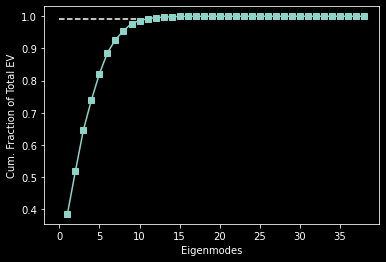

In [53]:
l, W = linalg.eig(C)
l = l.astype("double")

#explained_variance_ = (S ** 2) / (n_samples - 1)
#total_var = explained_variance_.sum()
#explained_variance_ratio_ = explained_variance_ / total_var

#print(l.cumsum() / l.sum())
print(np.cumsum(l**2) / np.sum(l**2) / n_samples)
print((l**2) / np.sum(l**2) / n_samples)

plt.plot(range(1,39), l.cumsum() / l.sum(), "-s")
plt.hlines([0.99], 0, 38, ls="--")
plt.gca().set_xlabel("Eigenmodes")
plt.gca().set_ylabel("Cum. Fraction of Total EV")

In [54]:
l

array([5.33453569e+05, 1.84215876e+05, 1.76709449e+05, 1.28798979e+05,
       1.12363701e+05, 8.95258512e+04, 5.65740152e+04, 3.80352073e+04,
       3.06771383e+04, 1.28612656e+04, 7.46491805e+03, 5.09433375e+03,
       2.34840203e+03, 1.62667352e+03, 1.28691331e+03, 3.71910017e+02,
       2.87871689e+02, 6.44320737e+01, 3.24261378e+01, 9.11347587e+00,
       2.93475228e+00, 8.30897450e-01, 3.14775279e-01, 8.12489028e-02,
       2.47680450e-02, 1.23834837e-02, 2.36757733e-03, 9.34171577e-04,
       1.51838834e-04, 2.37242690e-05, 3.75885504e-06, 1.41758973e-06,
       2.29997019e-07, 1.74093221e-07, 1.25403994e-07, 7.22749200e-08,
       4.12598394e-08, 1.88727942e-08])

In [55]:
W == W.T

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [56]:
r = 5

### Transformation of the design variables into the active subspace (dv_mat --> Y):

In [57]:
#Y = np.dot(W[:r,:], dv_mat.T).T
#Y.shape, dv_mat.shape

In [58]:
#Y = np.dot(W[:,:r], dv_mat.T).T
#Y.shape, dv_mat.shape

In [59]:
Y = dv_mat @ W[:,:r]
Y.shape, dv_mat.shape

((1836, 5), (1836, 38))

In [60]:
#Y = dv_mat @ pca.components_.T

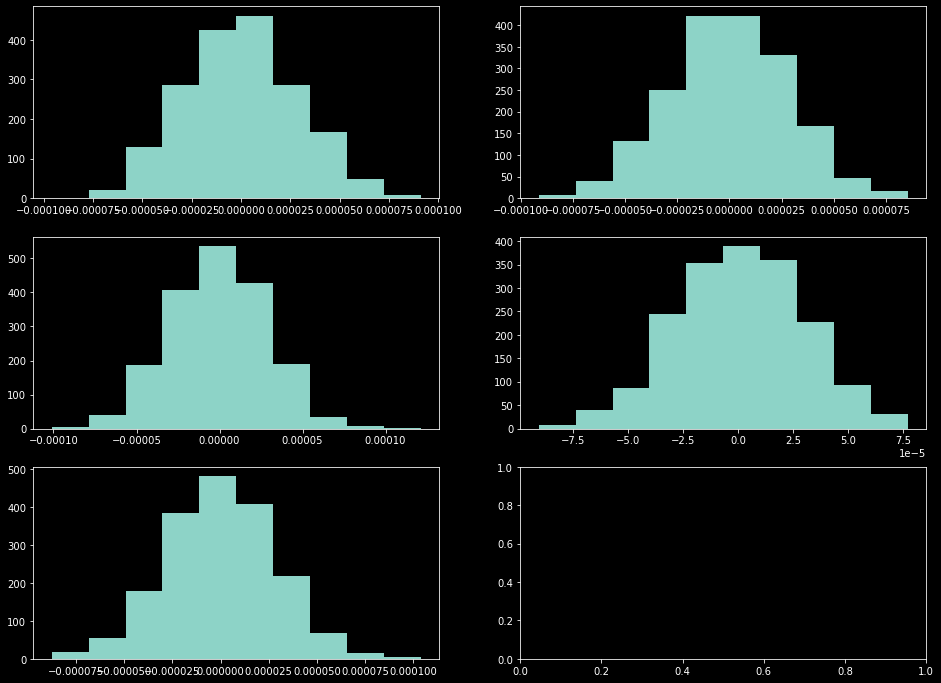

In [61]:
dimx = 2
dimy = int(np.ceil(r / dimx))


fig, axes = plt.subplots(dimy, dimx, figsize=(16, dimy*4))

#plt.gca().invert_yaxis()

for k, ax in enumerate(axes.flat):
    if k < r:
        ax.hist(Y[:,k])

In [62]:
#plt.hist(Y2[:,1])

In [63]:
#pca.singular_values_

In [64]:
aoa.shape

(1836,)

In [65]:
Y2 = np.hstack((Y, aoa.reshape(-1,1), ma.reshape(-1,1))) 

### Split data into train and test sets:
 (Arguably, this should be done before the unsupervised learning part/PCA)

In [66]:
from sklearn.model_selection import train_test_split

In [67]:
x_train, x_test, y_train, y_test = train_test_split(Y2, c_D, test_size=0.2, random_state=3)


### Fit a GaussianProcessRegressor to the training data and evaluate for train and test data:

In [68]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)


In [69]:
ls = length_scale = [1.e-05]*r
ls

[1e-05, 1e-05, 1e-05, 1e-05, 1e-05]

In [70]:
ls = 1. / l
ls = ls[:r]
ls = np.hstack((ls, 10., 1.))
ls

array([1.87457739e-06, 5.42841377e-06, 5.65900694e-06, 7.76403670e-06,
       8.89967129e-06, 1.00000000e+01, 1.00000000e+00])

#### Unfortunately, the GPR is very sensitive to the choice of kernel

In [71]:
kernel = Matern(length_scale=ls, nu=1.5) +  WhiteKernel(noise_level=1e-05, noise_level_bounds=(1e-09, 1e-04))

In [72]:
#kernel = RBF(length_scale=ls) + Matern(length_scale=ls, nu=1.5) #+ WhiteKernel() #+ RBF()

In [73]:
kernel = RBF() + WhiteKernel(noise_level=1e-05, noise_level_bounds=(1e-09, 1e-04))# + ConstantKernel()

In [74]:
kernel = RBF(length_scale=ls, length_scale_bounds=(1e-09, 1e04)) + WhiteKernel(noise_level=1e-05, noise_level_bounds=(1e-09, 1e-01))# + ConstantKernel()

In [75]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)
gp.fit(x_train, y_train)
print(gp.kernel_)
print(gp.score(x_train, y_train))
print(gp.score(x_test, y_test))

print(gp.log_marginal_likelihood())

RBF(length_scale=[0.00841, 0.00832, 0.0152, 0.0148, 0.00693, 12.4, 0.0453]) + WhiteKernel(noise_level=0.000108)
0.9968940860978793
0.9956933308018483
4183.077438974717


### Plot the prediction result of the GPR for training and test data:

Text(0.5, 1.0, 'Validation Data')

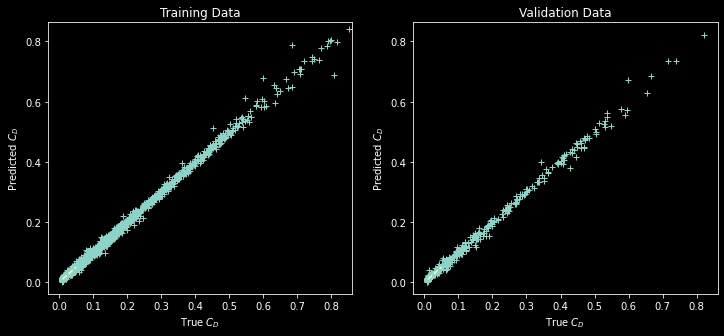

In [76]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)

y_pred = gp.predict(x_train)
#plt.plot(y_pred)
plt.plot(y_train, y_pred, '+')
plt.plot([0.01, 0.05], [0.01, 0.05], "--")

#plt.gca().set_xlim([0.008, 0.042])
#plt.gca().set_ylim([0.008, 0.042])
ax1 = plt.gca()
ax1.set_ylabel("Predicted $C_D$")
ax1.set_xlabel("True $C_D$")
ax1.set_title("Training Data")

plt.subplot(1, 2, 2)

y_pred = gp.predict(x_test)
#plt.plot(y_pred)
plt.plot(y_test, y_pred, '+', label="asd")
plt.plot([0.01, 0.05], [0.01, 0.05], "--")
#plt.plot(y_pred, 'o', c="r")
ax1.set_xlim(plt.gca().get_xlim())
ax1.set_ylim(plt.gca().get_ylim())
ax2 = plt.gca()
ax2.set_ylabel("Predicted $C_D$")
ax2.set_xlabel("True $C_D$")
ax2.set_title("Validation Data")

In [77]:
np.sqrt(np.sum(np.power(y_pred - y_test, 2)))/len(y_test), np.sum(np.abs(y_pred - y_test))/len(y_test)

(0.0005686305532009455, 0.007169549874786969)